## Periodic BCs and complex functions (system of PDEs)

For the final notebook of the first approach of PINNs, i.e. the approximation of a PDE's solution, we turn to a PDE of a complex function, $\psi\left(t,x\right)$, with periodic boundary conditions. More specifically, it is a variant of the Schrödinger 1D equation and it reads:

$$ i\frac{\partial \psi\left(t,x\right)}{\partial t} + \frac{1}{2} \frac{\partial^2 \psi\left(t,x\right)}{\partial x^2} + |\psi\left(t,x\right)|^2\psi\left(t,x\right) = 0, \hspace{10mm} \left(t,x\right) \in [0,\frac{\pi}{2}]\times\left[-5,5\right], \hspace{8mm} (1) $$

subject to the following initial and (periodic) boundary conditions

$$ \psi\left(t=0,x\right) = 2\text{sech}\left(x\right), \hspace{10mm} x \in \left[-5,5\right], $$

$$ \psi\left(t,x=-5\right) = \psi\left(t,x=5\right), \hspace{4mm} \frac{\partial \psi\left(t,x=-5\right)}{\partial t} = \frac{\partial \psi\left(t,x=5\right)}{\partial t}, \hspace{10mm} t \in \left[0,\frac{\pi}{2}\right]. $$

In [1]:
import jax 
import jax.numpy as jnp
import numpy as np
import optax
import flax.linen as nn

from typing import Sequence

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

We may define the real-valued functions $u\left(t,x\right)$, $v\left(t,x\right)$ such that

$$ \psi\left(t,x\right) = u\left(t,x\right) + iv\left(t,x\right) . $$

In this way, it is trivial to show that the PDE of Eq. (1) can be equivalently written as the following system of PDEs:

$$ \frac{\partial u\left(t,x\right)}{\partial t} + \frac{1}{2} \frac{\partial^2 v\left(t,x\right)}{\partial x^2} + \left(|v\left(t,x\right)|^2+|u\left(t,x\right)|^2\right)v\left(t,x\right) = 0,  $$

$$ \frac{\partial v\left(t,x\right)}{\partial t} - \frac{1}{2} \frac{\partial^2 u\left(t,x\right)}{\partial x^2} - \left(|v\left(t,x\right)|^2+|u\left(t,x\right)|^2\right)u\left(t,x\right) = 0  \hspace{10mm} (2) $$

The initial and boundary conditions now assume the form

$$ u\left(t=0,x\right) = 2\text{sech}\left(x\right), \hspace{4mm} v\left(t=0,x\right) = 0, \hspace{10mm} x \in \left[-5,5\right], $$

$$ u\left(t,x=-5\right) = u\left(t,x=5\right), \hspace{4mm} v\left(t,x=-5\right) = v\left(t,x=5\right), \hspace{10mm} t \in \left[0,\frac{\pi}{2}\right], $$

$$ \frac{\partial u\left(t,x=-5\right)}{\partial t} = \frac{\partial u\left(t,x=5\right)}{\partial t}, \hspace{4mm} \frac{\partial v\left(t,x=-5\right)}{\partial t} = \frac{\partial v\left(t,x=5\right)}{\partial t}, \hspace{10mm} t \in \left[0,\frac{\pi}{2}\right]. $$

In [2]:
N_0, N_b, N_f = 250, 250, 20_000

# Domains of t and x
tmin, tmax = 0.0, np.pi/2
xmin, xmax = -5.0, 5.0

# seed key for debugging
np.random.seed(420)

# ----------------------------------------------------------
# Initial Condition (IC): u(t=0,x) = 2sech(x), v(t=0,x) = 0
# ----------------------------------------------------------

t_0 = jnp.ones([N_0,1],dtype='float32')*0.0
x_0 = np.random.uniform(low=xmin,high=xmax,size=(N_0,1))
u_0 = 2.0/jnp.cosh(x_0)
v_0 = jnp.ones([N_0,1],dtype='float32')*0.0
IC = jnp.concatenate([t_0,x_0,u_0,v_0],axis=1)

# ---------------------------------
# Boundary condition points (BC)
# ---------------------------------

t_b = np.random.uniform(low=tmin,high=tmax,size=(N_b,1))
x_b1 = jnp.ones([N_b,1],dtype='float32')*5.0
x_b2 = -jnp.ones([N_b,1],dtype='float32')*5.0
BC = jnp.concatenate([t_b,x_b1,x_b2],axis=1)

conds = [IC,BC]

t_c = np.random.uniform(low=tmin,high=tmax,size=(N_f,1))
x_c = np.random.uniform(low=xmin,high=xmax,size=(N_f,1))

colloc = jnp.concatenate([t_c,x_c],axis=1)

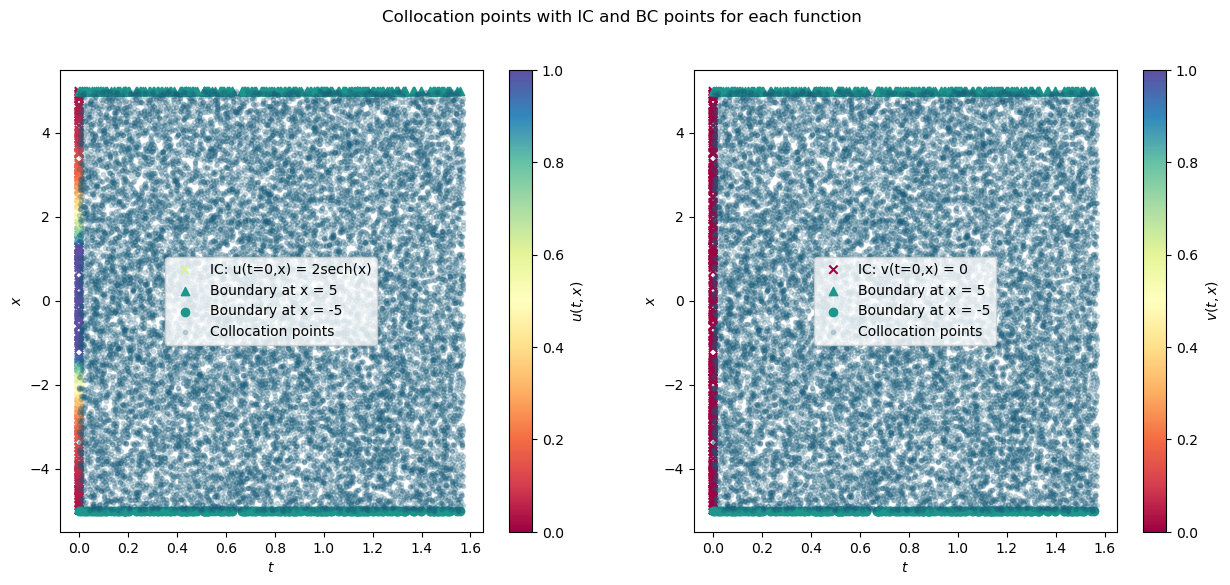

In [3]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

plt.suptitle('Collocation points with IC and BC points for each function')

cmap = 'Spectral'

axes[0].scatter(t_0, x_0, c=u_0, marker='x', vmin=0, vmax=1, label='IC: u(t=0,x) = 2sech(x)', cmap=cmap)
axes[0].scatter(t_b, x_b1, color='#1f968b', marker='^', label='Boundary at x = 5')
axes[0].scatter(t_b, x_b2, color='#1f968b', marker='o', label='Boundary at x = -5')
axes[0].scatter(t_c, x_c, color='#1a5d7b', marker='.', alpha=0.2, label='Collocation points')

axes[0].set(xlabel=r'$t$', ylabel=r'$x$')

axes[1].scatter(t_0, x_0, c=v_0, marker='x', vmin=0, vmax=1, label='IC: v(t=0,x) = 0', cmap=cmap)
axes[1].scatter(t_b, x_b1, color='#1f968b', marker='^', label='Boundary at x = 5')
axes[1].scatter(t_b, x_b2, color='#1f968b', marker='o', label='Boundary at x = -5')
axes[1].scatter(t_c, x_c, color='#1a5d7b', marker='.', alpha=0.2, label='Collocation points')

axes[1].set(xlabel=r'$t$', ylabel=r'$x$')

cbar1 = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=axes[0])
cbar1.set_label(r'$u(t,x)$', rotation=90)
            
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=axes[1])
cbar2.set_label(r'$v(t,x)$', rotation=90)

axes[0].legend(loc='center')
axes[1].legend(loc='center')
plt.show()

In [4]:
class MLP(nn.Module):
    features: Sequence[int]

    def setup(self):
        self.layers = [nn.Dense(features=feat, use_bias=True) for feat in self.features]
        
    def __call__(self, inputs):
        x = inputs
        for idx, layer in enumerate(self.layers):
            x = layer(x)
            if idx != len(self.layers)-1:
                x = jnp.tanh(x)
        return x

The loss functions corresponding to the initial and boundary conditions imposed on $u\left(t,x\right)$ and $v\left(t,x\right)$ are:

$$ \text{MSE}_0 = \frac{1}{N_0} \sum_{i=1}^{N_0}{\left[\left|u\left(t=0,x_0^i\right) - u_0^i\right|^2 + \left|v\left(t=0,x_0^i\right) - v_0^i\right|^2\right]} $$

$$ \begin{align}
\text{MSE}_b = &\frac{1}{N_b} \sum_{i=1}^{N_b}{\left[\left|u\left(t_b,x=-5\right) - u\left(t_b,x=5\right)\right|^2 + \left|v\left(t_b,x=-5\right) - v\left(t_b,x=5\right)\right|^2\right]} ~+\\ 
&\frac{1}{N_b}\sum_{i=1}^{N_b}{\left[\left|\frac{\partial u\left(t_b,x=-5\right)}{\partial t} - \frac{\partial u\left(t_b,x=5\right)}{\partial t}\right|^2 + \left|\frac{\partial v\left(t_b,x=-5\right)}{\partial t} - \frac{\partial v\left(t_b,x=5\right)}{\partial t}\right|^2\right]}
\end{align}$$

In [5]:
@jax.jit
def MSE(true,pred):
    return jnp.mean((true-pred)**2)
    
@jax.jit
def NN(params,t,x):
    func = model.apply(params, jnp.concatenate((t,x),axis=1))
    return func

def loss_fun(params,colloc,conds):
    
    # Call the u, v nets with their current params
    ufunc = lambda t,x : NN(params,t,x)[:,[0]]
    vfunc = lambda t,x : NN(params,t,x)[:,[1]]
    
    IC, BC = conds[0], conds[1]
    
    # For IC
    t_0, x_0, u_0, v_0 = IC[:,[0]], IC[:,[1]], IC[:,[2]], IC[:,[3]]
    mse_0 = MSE(u_0,ufunc(t_0,x_0)) + MSE(v_0,vfunc(t_0,x_0))
    
    # For BC
    t_b, x_b1, x_b2 = BC[:,[0]], BC[:,[1]], BC[:,[2]]
    mse_b = MSE(ufunc(t_b,x_b1),ufunc(t_b,x_b2)) + MSE(vfunc(t_b,x_b1),vfunc(t_b,x_b2))
    
    u_t = lambda t,x : jax.grad(lambda t,x : jnp.sum(ufunc(t,x)),0)(t,x)
    v_t = lambda t,x : jax.grad(lambda t,x : jnp.sum(vfunc(t,x)),0)(t,x)
    
    mse_b += MSE(u_t(t_b,x_b1),u_t(t_b,x_b2))
    mse_b += MSE(v_t(t_b,x_b1),v_t(t_b,x_b2))
        
    # The physics-informed part
    t_c, x_c = colloc[:,[0]], colloc[:,[1]]
    
    u_x = lambda t,x : jax.grad(lambda t,x : jnp.sum(ufunc(t,x)),1)(t,x)
    u_xx = lambda t,x : jax.grad(lambda t,x : jnp.sum(u_x(t,x)),1)(t,x)
    v_x = lambda t,x : jax.grad(lambda t,x : jnp.sum(vfunc(t,x)),1)(t,x)
    v_xx = lambda t,x : jax.grad(lambda t,x : jnp.sum(v_x(t,x)),1)(t,x)
    
    PINN_a = u_t(t_c,x_c) + 0.5*v_xx(t_c,x_c) + (vfunc(t_c,x_c)**2+ufunc(t_c,x_c)**2)*vfunc(t_c,x_c)
    PINN_b = v_t(t_c,x_c) - 0.5*u_xx(t_c,x_c) - (vfunc(t_c,x_c)**2+ufunc(t_c,x_c)**2)*ufunc(t_c,x_c)
    mse_pinn = jnp.mean(PINN_a**2 + PINN_b**2)
    
    tot_loss = mse_pinn + mse_0 + mse_b
    return tot_loss

@jax.jit
def update(opt_state,params,colloc,conds):
    # Get the gradient w.r.t to MLP params
    grads=jax.jit(jax.grad(loss_fun,0))(params,colloc,conds)

    # Update params
    updates, opt_state = optimizer.update(grads, opt_state)
    
    # Apply the update
    params = optax.apply_updates(params, updates)

    return opt_state, params

def init_process(features):
    
    model = MLP(features)

    key1, key2 = jax.random.split(jax.random.PRNGKey(420),num=2)

    dummy_in = jax.random.normal(key1, (2,))
    params = model.init(key2, dummy_in)

    lr = optax.piecewise_constant_schedule(1e-2,{10_000:5e-3,30_000:1e-3,50_000:5e-4,70_000:1e-4})
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)
    
    return model, params, optimizer, opt_state

def plot_results(T, X, results):
    fig, ax = plt.subplots(figsize=(8,5))

    c = ax.pcolormesh(T, X, results, cmap='Spectral')

    plt.xlabel(r'$t$')
    plt.ylabel(r'$x$')
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
    plt.yticks([-5, 0, 5])
    plt.title('PINN Solution of the PDE')

    cbar = plt.colorbar(c, ax=ax)
    cbar.set_label(r'$|\psi(t,x)|$', rotation=90)

    plt.show()

Initialize and train the model.

In [6]:
features = [20, 20, 20, 20, 20, 20, 10, 2]

model, params, optimizer, opt_state = init_process(features)

In [7]:
%%time
epochs = 30_000
for epoch in range(epochs):
    opt_state, params = update(opt_state,params,colloc,conds)

    # print loss and epoch info
    if epoch%(1000) == 0:
        print(f'Epoch = {epoch},\tloss = {loss_fun(params,colloc,conds):.3e}')

Epoch = 0,	loss = 3.238e+00
Epoch = 1000,	loss = 3.487e-02
Epoch = 2000,	loss = 2.462e-02
Epoch = 3000,	loss = 2.045e-02
Epoch = 4000,	loss = 1.653e-02
Epoch = 5000,	loss = 2.062e-02
Epoch = 6000,	loss = 1.337e-02
Epoch = 7000,	loss = 1.212e-02
Epoch = 8000,	loss = 2.389e-02
Epoch = 9000,	loss = 8.647e-03
Epoch = 10000,	loss = 2.284e-02
Epoch = 11000,	loss = 7.605e-03
Epoch = 12000,	loss = 7.534e-03
Epoch = 13000,	loss = 7.449e-03
Epoch = 14000,	loss = 7.327e-03
Epoch = 15000,	loss = 7.143e-03
Epoch = 16000,	loss = 6.855e-03
Epoch = 17000,	loss = 6.424e-03
Epoch = 18000,	loss = 5.842e-03
Epoch = 19000,	loss = 5.121e-03
Epoch = 20000,	loss = 4.367e-03
Epoch = 21000,	loss = 3.709e-03
Epoch = 22000,	loss = 3.155e-03
Epoch = 23000,	loss = 2.704e-03
Epoch = 24000,	loss = 2.350e-03
Epoch = 25000,	loss = 2.073e-03
Epoch = 26000,	loss = 1.847e-03
Epoch = 27000,	loss = 1.655e-03
Epoch = 28000,	loss = 1.491e-03
Epoch = 29000,	loss = 1.347e-03
CPU times: user 4min 2s, sys: 2min 55s, total: 6min 5

The trained model essentially corresponds to the $u\left(t,x\right)$ and $v\left(t,x\right)$ functions, which are equivalent to the unknown wavefunction, $\psi\left(t,x\right)$. The figure below corresponds to the norm of the wavefunction, $|\psi\left(t,x\right)|$.

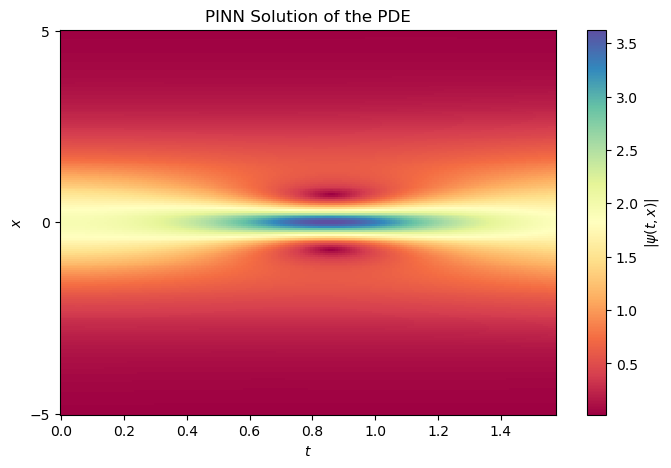

In [8]:
N_grid = 200 # Defines the grid on which to draw the solution
tspace = np.linspace(tmin, tmax, N_grid)
xspace = np.linspace(xmin, xmax, N_grid)
T, X = np.meshgrid(tspace, xspace)

results = NN(params,T.flatten().reshape(-1,1),X.flatten().reshape(-1,1))
u_res, v_res = results[:,[0]].reshape(N_grid,N_grid), results[:,[1]].reshape(N_grid,N_grid)

plot_results(T, X, np.sqrt(u_res**2+v_res**2))